[View in Colaboratory](https://colab.research.google.com/github/liannesr/Lab-2-Machine-Learning/blob/master/Lianne_S%C3%A1nchez_Lab_2_Training_Your_First_TF_Linear_Regression_Model.ipynb)

#### Copyright 2018 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Imports and Pandas Options
We import the libraries we are using and set some panda options.

In [0]:
import fnmatch
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

# This line increasing the amount of logging when there is an error.  You can
# remove it if you want less logging
tf.logging.set_verbosity(tf.logging.ERROR)

# Set the output display to have one digit for decimal places, for display
# readability only and limit it to printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

### Data Set
As in the last lab we use the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile)  from 1985 Ward's Automotive Yearbook that is part of the  [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets) 

### Load and randomizing the data
Load the data using the column names from [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile). When using SGD (stochastic graident descent) for training it is important that **each batch is a random sample of the data** so that the gradient computed is representative.  While there appears to be no order to this data set, it is always good practice to shuffle the data to be in a random order.


In [0]:
# Provide the names for the columns since the CSV file with the data does
# not have a header row.
cols = ['symboling', 'losses', 'make', 'fuel-type', 'aspiration', 'num-doors',
        'body-style', 'drive-wheels', 'engine-location', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-type', 'num-cylinders',
        'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
        'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']


# Load in the data from a CSV file that is comma seperated.
car_data = pd.read_csv('https://storage.googleapis.com/ml_universities/cars_dataset/cars_data.csv',
                        sep=',', names=cols, header=None, encoding='latin-1')

# We'll then randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of Stochastic Gradient
# Descent.
car_data = car_data.reindex(np.random.permutation(car_data.index))

###Visualizing a Linear Model Using a Scatter Plot

When training a linear regression model over a single variable, a really nice thing to be able to do is to show the model (which is just a line) as part of the scatter plot. That really helps you see how well the model fits the data. Just looking at the loss (RMSE here) doesn't really indicate how good the model is. Sometimes you want to show several models on the same scatter plot to compare them so we allow slopes, biases, and model_names to all be lists. They should be of the same size giving the weight (slope), bias, and name (to use in the legend) for the model.

In [0]:
def scatter_plot(features, targets, slopes=[], biases=[], model_names=[]):
  """ Creates a scatter plot of input_feature vs target along with the models.
  
  Args:
    features: list of the input features
    targets: list of targets
    slopes: list of model weight (slope) 
    bias: list of model bias (same size as slopes)
    model_names: list of model_names to use for legend (same size as slopes)
  """      
  # Define some colors to use that go from blue towards red
  colors = [cm.coolwarm(x) for x in np.linspace(0, 1, len(slopes))]
  
  # Generate the Scatter plot
  plt.ylabel("target")
  plt.xlabel("input feature")
  plt.scatter(features, targets, color='black', label="")
  # Add the lines corresponding to the provided models
  for i in range (0, len(slopes)):
    y_0 = slopes[i] * features.min() + biases[i]
    y_1 = slopes[i] * features.max() + biases[i]
    plt.plot([features.min(), features.max()], [y_0, y_1],
             label=model_names[i], color=colors[i])
  if (len(model_names) > 0):
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Converting Missing Numerical Values to the Column Mean

As you hopefully found in the last exercise, a good option for replacing missing entries (NaN) is to replace them by the column mean.  We do that here.

In [0]:
car_data['price'] = pd.to_numeric(car_data['price'], errors='coerce')
car_data['horsepower'] = pd.to_numeric(car_data['horsepower'], errors='coerce')
car_data['peak-rpm'] = pd.to_numeric(car_data['peak-rpm'], errors='coerce')
car_data['city-mpg'] = pd.to_numeric(car_data['city-mpg'], errors='coerce')
car_data['highway-mpg'] = pd.to_numeric(car_data['highway-mpg'], errors='coerce')

# Replace nan by the mean storing the solution in the same table (`inplace')
car_data.fillna(car_data.mean(), inplace=True)

### Build Your First Tensor Flow Model

We now build a model to predict `price`, which will be our label (sometimes also called a target) using `horsepower` as our input feature. To train our model, we'll use the [LinearRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor) interface provided by the TensorFlow [Estimator](https://www.tensorflow.org/get_started/estimator) API. This API takes care of a lot of the low-level model plumbing, and exposes convenient methods for performing model training, evaluation, and inference.

###Prepare Features
As our learning models get more sophisticated we will want to do some computation on the features and even generate new features from the existing features. We will see examples of this in later labs.  For now this method will just make a copy of a portion of the dataframe.

In [0]:
def prepare_features(dataframe):
  """Prepares the features for provided dataset.

  Args:
    dataframe: A Pandas DataFrame expected to contain data from the
      desired data set.
  Returns:
    A new dataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()
  return processed_features

###Generate the Training Examples
We simple call `prepare_features` on the `car_data` dataframe.

In [0]:
training_examples = prepare_features(car_data)

###Setting Up the Feature Columns for TensorFlow

In order to import our training data into TensorFlow, we need to specify what type of data each feature contains. There are two main types of data we'll use in this and future exercises:

* **Numerical Data**: Data that is a number (integer or float) and that you want to treat as a number. As we will discuss more later sometimes you might want to treat numerical data (e.g., a postal code) as if it were categorical.

* **Categorical Data**: Data that is textual such as `make` or 'fuel-type`.

In TensorFlow, we indicate a feature's data type using a construct called a **feature column**. Feature columns store only a description of the feature data; they do not contain the feature data itself.

For now, we will just use numerical features.  Later you wll learn how to use categorical data.

In [0]:
NUMERICAL_FEATURES = ["horsepower"]

def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(feature)
              for feature in NUMERICAL_FEATURES])

### Input Function
To import our data into a LinearRegressor, we need to define an input function, which instructs TensorFlow how to preprocess the data, as well as how to batch, shuffle, and repeat it during model training.

First, we'll convert our Pandas feature data into a dictionary of NumPy arrays. We can then use the TensorFlow Dataset API to construct a dataset object from our data, and then break our data into batches of batch_size, to be repeated for the specified number of epochs (num_epochs).

When the default value of num_epochs=None is passed to repeat(), the input data will be repeated indefinitely.

Next, if shuffle is set to True, we'll shuffle the data so that it's passed to the model randomly during training. The buffer_size argument specifies the size of the dataset from which shuffle will randomly sample.

Finally, our input function constructs an iterator for the dataset and returns the next batch of data to the LinearRegressor.

**NOTE:** We'll continue to use this same input function in later exercises. For more
detailed documentation of input functions and the `Dataset` API, see the [TensorFlow Programmer's Guide](https://www.tensorflow.org/programmers_guide/datasets).

In [0]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Defines a function to preprocess the data, as well as how to batch,
      shuffle, and repeat it during model training..
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Define Input Functions Using the Training Data

We can now use a labda function to create an input function to use when training the model, and one to use when evaluating the model's loss on the training data.

In [0]:
NUMERICAL_FEATURES = ["horsepower"]
CATEGORICAL_FEATURES = []
LABEL = "price"  

# Here we define an input functon that uses the training examples generating
# batches of 10 examples
training_input_fn = lambda: input_fn(
    training_examples[NUMERICAL_FEATURES], training_examples[LABEL], 
    batch_size=10)

# Here we define an input function that will compute the loss over the entire
# training set.
predict_training_input_fn = lambda: input_fn(
    training_examples[NUMERICAL_FEATURES], training_examples[LABEL], 
    num_epochs=1, shuffle=False)

### Test the Input Functions
It is always good to check components of your code to make debugging easier.  Here is a simple procedure that calls `train_input_fn` and `predict_input_fn` to generate batches to use for training.

In [0]:
feature_batch, label_batch = predict_training_input_fn()
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  print(sess.run((feature_batch, label_batch)))

({'horsepower': array([160.])}, array([18399.]))


###Configure the LinearRegressor

Next, we'll configure a linear regression model using LinearRegressor. We'll train this model using the `GradientDescentOptimizer`, which implements Mini-Batch Stochastic Gradient Descent (SGD). The `learning_rate` argument controls the size of the gradient step.

**NOTE:** To be safe, we also apply [gradient clipping](https://developers.google.com/machine-learning/glossary/#gradient_clipping) to our optimizer via `clip_gradients_by_norm`. Gradient clipping ensures the magnitude of the gradients do not become too large during training, which can cause gradient descent to fail. 

In [0]:
def define_linear_regression_model(learning_rate):
  """ Defines a linear regression model of one feature to predict the target.
  
  Args:
    learning_rate: A `float`, the learning rate
    batch_size: A non-zero `int`, the batch size.
    
  Returns:
    A linear regressor created with the given parameters
  """
  
  optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=construct_feature_columns(),
    optimizer=optimizer
  )  
  return linear_regressor

##Train the Model

We now have all the pieces we need to train a model.  In order to generate intermediate losses for the learning curve (and record as we are training), we divide the training into 10 periods.  After each period we compute the loss.  We also store the weight and bias of the model at that time so that we can then visually show how the model evolves in a scatter plot.  You are welcome to modify the number of periods but 10 seems to work out pretty well.

In [0]:
NUMERICAL_FEATURES = ["horsepower"]
CATEGORICAL_FEATURES = []
LABEL = "price"
BATCH_SIZE = 100

# Create regression model using the define_regression_model procedure that we
# defined earlier.
linear_regressor = define_linear_regression_model(learning_rate = 1)

train_input_fn = lambda: input_fn(training_examples[NUMERICAL_FEATURES], 
                                  training_examples[LABEL], 
                                  batch_size=50)
# Train the predictor using 100 steps through the data.
_ = linear_regressor.train(
      input_fn=train_input_fn, steps=100
)

### Evaluate the Model

Let's make predictions on that training data, to see how well our model fit it during training.

**NOTE:** Training error measures how well your model fits the training data, but it **_does not_** measure how well your model **_generalizes to new data_**. In later exercises, you'll explore how to split your data to evaluate your model's ability to generalize.


In [0]:
features = training_examples[NUMERICAL_FEATURES]
targets = training_examples[LABEL]
training_predict_input_fn = lambda: input_fn(
    features, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=training_predict_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 27019472.121
Root Mean Squared Error (on training data): 5198.026


### Looking at the Feature Weight (Slope) and Bias of Our Trained Model

TensorFlow provides an easy way to view the weights of the trained model. Although we just have a single feature right now, this code block shows how you could access and print all of the feature weights for a linear model.

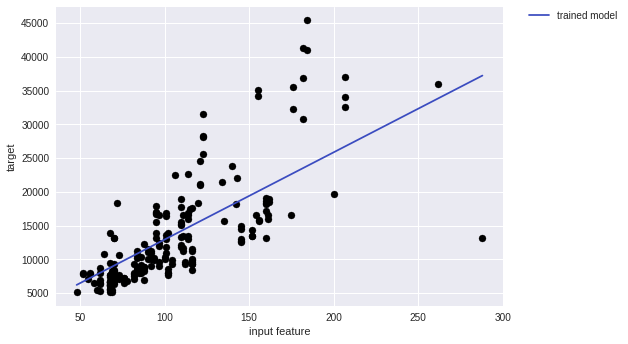

In [0]:
w = linear_regressor.get_variable_value('linear/linear_model/horsepower/weights')[0]
b = linear_regressor.get_variable_value('linear/linear_model/bias_weights')[0]
scatter_plot(features.values, targets,[w], [b], ['trained model'])

## Computing the Loss
For now we are using root mean squared error (RMSE) for our loss since that is the appropriate loss to use for linear regression.  However, to keep the procedure to train the model very generic, we will use a method compute loss that can be tailored to other types of problems. For this lab, our implementation will be to return the RMSE.


In [0]:
def compute_loss(predictions, targets):
  """ Computes the loss (RMSE) for linear regression.
  
  Args:
    predictions: a list of values predicted by the model being visualized
    targets: a list of the target values being predicted that must be the
             same size as predictions.
    
  Returns:
    The RMSE for the provided predictions and targets
  """      
  return math.sqrt(metrics.mean_squared_error(predictions, targets))

##Learning Curve

Another important tool is a graph often called a **learning curve** that shows the loss being minimized on the y-axis and the training steps (time) on the x-axis.  Looking at the learning curve will help you understand if you have set the `learning_rate` too high or too low, how many `steps` you need to train and other things that we'll explore later.  

Next we define a method to plot the learning curve given a list of training losses that will be recorded at regular intervals during training.

In [0]:
def plot_learning_curve(training_losses):
  """ Plot the learning curve
  
  Args:
    training_loses: a list of losses to plot
  """        
  plt.ylabel('Loss')
  plt.xlabel('Training Steps')
  plt.plot(training_losses)

###Training Our Model with a Learning Curve and Scatter Plot

We now have all the pieces we need to train a model in a way that we can tune the learning rate and  visually evaluate how the model is performing.  In order to generate intermediate losses for the learning curve (and record as we are training), we divide the training into 10 periods.  After each period we compute the loss.  We also store the weight and bias of the model at that time so that we can then visually show how the model evolves in a scatter plot.  You are welcome to modify the number of periods but 10 seems to work out pretty well. 

We start by using a *scatter plot* as our visualization for understanding how the model evolves when training but this can only easily be done with a single numerical feature.  Later we will switch to a different visualization that can be used for any linear model.

In [0]:
# Function to train the model when there is a single numeric feature, which
# allows using the scatter plot as a visualization with the progession of the
# model.
def train_model_with_one_numerical_feature(linear_regressor, features, labels,
                                           steps, batch_size):
  """Trains a linear regression model.
  
  Args:
    linear_regressor: The regressor to train
    features: The list of input feature values
    labels: The label values
    steps: A non-zero `int`, the total number of training steps.
    batch_size: A non-zero `int`, the batch size.
    
  Returns:
    The trained regressor
  """
  # In order to see how the model evolves as we train it, we will divide the
  # steps into periods and show the model after each period.
  periods = 10
  steps_per_period = steps / periods
  
  # Set up the training_input_fn and predict_training_input_fn
  training_input_fn = lambda: input_fn(features, labels, batch_size=batch_size)
  predict_training_input_fn = lambda: input_fn(features, labels, num_epochs=1,
                                               shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.  We store the loss, slope (feature weight), bias, and a name
  # for the model when there is a single feature (which would then allos us
  # to plot the model in a scatter plot).
  print("Training model...")
  training_losses = []
  slopes = []
  biases = []
  model_names = []

  for period in range (0, periods):
    # Call fit to train the regressor for steps_per_period steps
    _ = linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period)

    # Use the predict method to compute the predictions from the current model
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
   
    # Compute the loss between the predictions and the correct labels, append
    # the loss to the list of losses used to generate the learning curve after
    # training is cmplete and print the current loss
    loss = compute_loss(predictions, labels)
    training_losses.append(loss) 
    print("  Loss after period %02d : %0.3f" % (period, loss))
    
    # Add slope, bias and model_name to the lists to be used later to plot
    # the model after each training period.
    feature_weight = fnmatch.filter(linear_regressor.get_variable_names(),
                                    'linear/linear_model/*/weights')
    slopes.append(linear_regressor.get_variable_value(feature_weight[0])[0])
    biases.append(linear_regressor.get_variable_value(
        'linear/linear_model/bias_weights')[0])
    model_names.append("period_" + str(period))
      
  # Now that training is done print the final loss    
  print("Final Loss (RMSE) on the training data: %0.3f" % loss) 
  
  # Generate a figure with the learning curve on the left and a scatter plot
  # on the right
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Learning Curve (RMSE vs time)")
  plot_learning_curve(training_losses)
  plt.subplot(1, 2, 2)
  plt.tight_layout(pad=1.1, w_pad=3.0, h_pad=3.0)
 
  plt.title("Learned Model by Period on Scatter Plot")
  scatter_plot(features.values, labels, slopes, biases, model_names)   
  return linear_regressor

### Example Learning Curve When the Learning Rate is Too High

When the learning rate is too high you will see the loss going up and down indicating you are making adjustments that are too large.  When you see this happening lower the learning rate (initially by a factor of 10 and then make smaller adjustments when you are close).  In this case you are moving back and forth between having the slope too large and too small.

Training model...
  Loss after period 00 : 41600.879
  Loss after period 01 : 15363.677
  Loss after period 02 : 41600.909
  Loss after period 03 : 15363.228
  Loss after period 04 : 41601.121
  Loss after period 05 : 15363.153
  Loss after period 06 : 41600.997
  Loss after period 07 : 15363.290
  Loss after period 08 : 41600.862
  Loss after period 09 : 15363.457
Final Loss (RMSE) on the training data: 15363.457


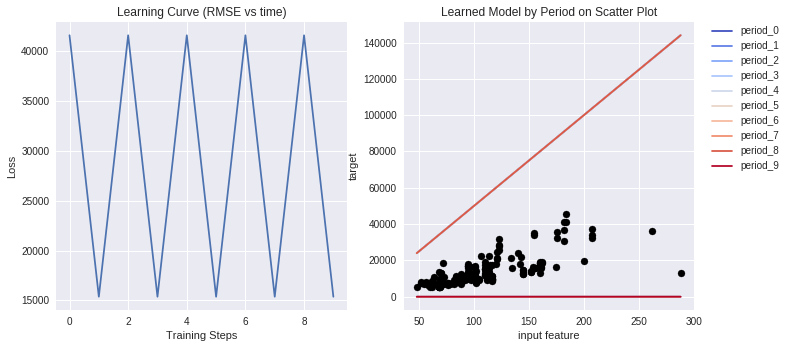

In [0]:
NUMERICAL_FEATURES = ["horsepower"]
CATEGORICAL_FEATURES = []
LABEL = "price"

LEARNING_RATE = 100
BATCH_SIZE = 50
STEPS = 50

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model_with_one_numerical_feature(
    linear_regressor, training_examples[NUMERICAL_FEATURES],
    training_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

### Example Learning Curve When the Learning Rate is Too Low

When the learning rate is too low then the changes are too small.  While this might eventually get you to a good solution it would take way more steps than needed and the training time is roughly proportinal to the number of steps so you want to find a learning rate that gets you to a good solution as fast as you can.  You can see for these settings that the model learned (the line you see in the scatter plot) is improving and would eventually get there but is taking much, much longer than needed to train.

Training model...
  Loss after period 00 : 14840.460
  Loss after period 01 : 14319.774
  Loss after period 02 : 13801.920
  Loss after period 03 : 13287.341
  Loss after period 04 : 12776.364
  Loss after period 05 : 12269.415
  Loss after period 06 : 11766.903
  Loss after period 07 : 11269.476
  Loss after period 08 : 10777.926
  Loss after period 09 : 10293.096
Final Loss (RMSE) on the training data: 10293.096


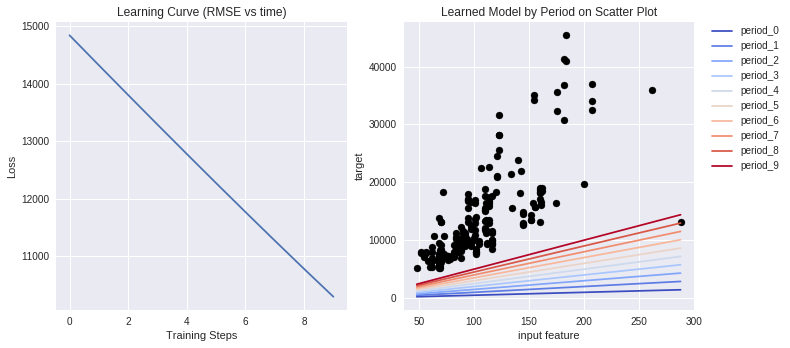

In [0]:
NUMERICAL_FEATURES = ["horsepower"]
CATEGORICAL_FEATURES = []
LABEL = "price"

LEARNING_RATE = 0.001
BATCH_SIZE = 50
STEPS = 10000

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model_with_one_numerical_feature(
    linear_regressor, training_examples[NUMERICAL_FEATURES],
    training_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

##Exercise: Modify the hyperparmaters to get a better model (1 Point)
For this task, you can use the code block below that puts all the above code in a single cell for convenience. Focus on first finding a good learning rate and then adjusting the number of steps to be what you need to converge.


In [0]:
NUMERICAL_FEATURES = ["horsepower"]
CATEGORICAL_FEATURES = []
LABEL = "price"

## Fill in the rest of your solution here.  Feel free to introduce multiple
## code boxes if you want to see the solutions and learning curves from
## different options at the same time

Training model...
  Loss after period 00 : 10293.097
  Loss after period 01 : 6163.876
  Loss after period 02 : 5317.500
  Loss after period 03 : 5227.575
  Loss after period 04 : 5226.328
  Loss after period 05 : 5226.799
  Loss after period 06 : 5226.700
  Loss after period 07 : 5225.686
  Loss after period 08 : 5225.530
  Loss after period 09 : 5224.981
Final Loss (RMSE) on the training data: 5224.981


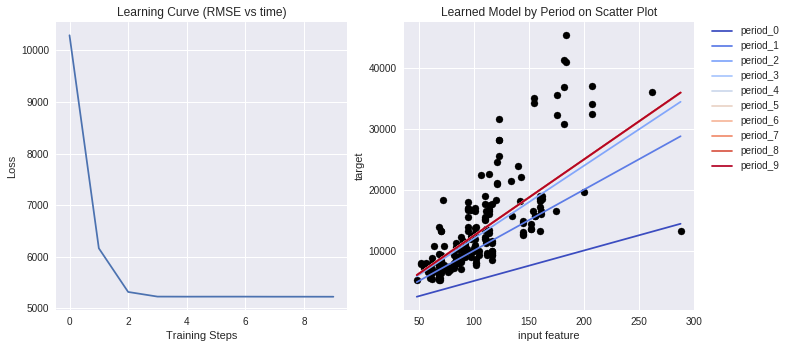

In [0]:
LEARNING_RATE = 0.001
BATCH_SIZE = 50
STEPS = 100000
#PLOT 1; 5224.981; 100,000
linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model_with_one_numerical_feature(
    linear_regressor, training_examples[NUMERICAL_FEATURES],
    training_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Loss after period 00 : 5219.673
  Loss after period 01 : 5210.146
  Loss after period 02 : 5202.578
  Loss after period 03 : 5195.413
  Loss after period 04 : 5189.653
  Loss after period 06 : 5179.898
  Loss after period 07 : 5175.861
  Loss after period 08 : 5171.974
  Loss after period 09 : 5170.073
Final Loss (RMSE) on the training data: 5170.073


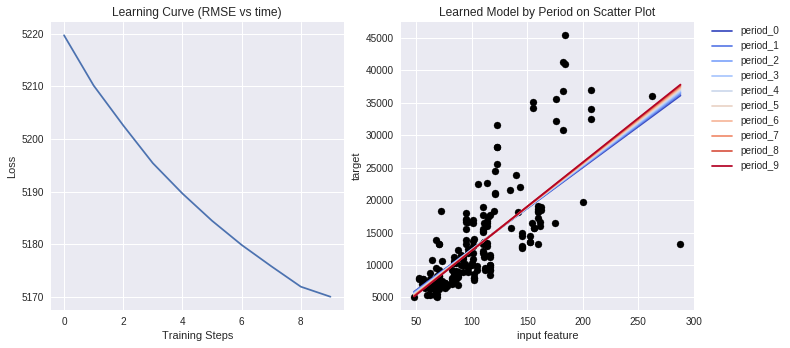

In [0]:
LEARNING_RATE = 0.003
BATCH_SIZE = 50
STEPS = 1000000
#PLOT 2; 5170.073; 1,000,000
linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model_with_one_numerical_feature(
    linear_regressor, training_examples[NUMERICAL_FEATURES],
    training_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Loss after period 00 : 6163.075
  Loss after period 01 : 5227.399
  Loss after period 02 : 5227.111
  Loss after period 03 : 5224.544
  Loss after period 04 : 5226.775
  Loss after period 05 : 5224.225
  Loss after period 06 : 5221.800
  Loss after period 07 : 5223.934
  Loss after period 08 : 5228.408
  Loss after period 09 : 5228.063
Final Loss (RMSE) on the training data: 5228.063


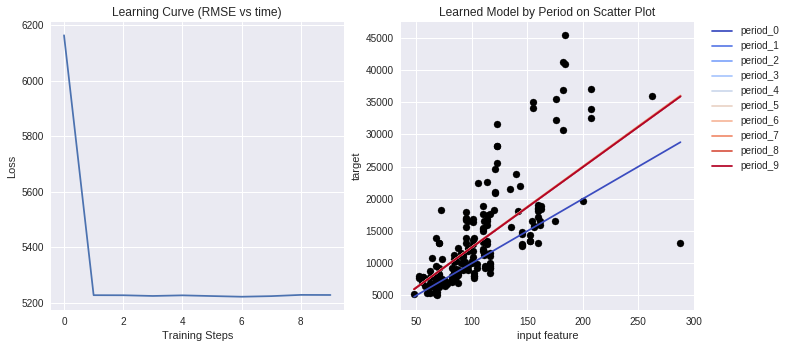

In [0]:
LEARNING_RATE = 0.02
BATCH_SIZE = 50
STEPS = 10000
#PLOT 3; 5228.063; 10,000
linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model_with_one_numerical_feature(
    linear_regressor, training_examples[NUMERICAL_FEATURES],
    training_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Loss after period 00 : 8012.734
  Loss after period 01 : 5313.044
  Loss after period 02 : 5228.257
  Loss after period 03 : 5226.201
  Loss after period 04 : 5226.257
  Loss after period 05 : 5226.051
  Loss after period 06 : 5222.445
  Loss after period 07 : 5225.575
  Loss after period 08 : 5227.139
  Loss after period 09 : 5228.717
Final Loss (RMSE) on the training data: 5228.717


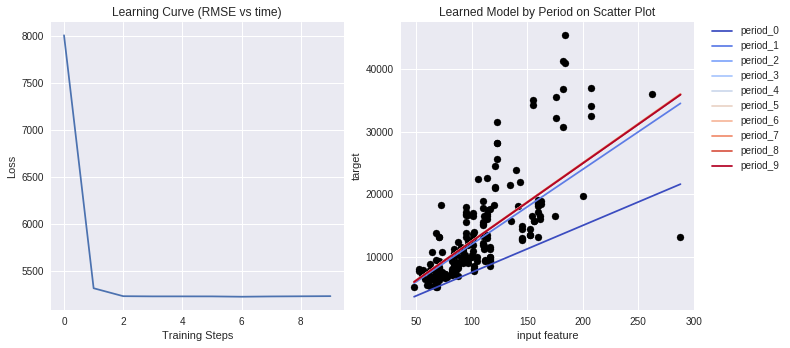

In [0]:
LEARNING_RATE = 0.015
BATCH_SIZE = 50
STEPS = 10000
#PLOT 4; 5228.717; 10,000
linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model_with_one_numerical_feature(
    linear_regressor, training_examples[NUMERICAL_FEATURES],
    training_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Loss after period 00 : 9816.372
  Loss after period 01 : 5643.096
  Loss after period 02 : 5283.459
  Loss after period 03 : 5227.413
  Loss after period 04 : 5228.696
  Loss after period 05 : 5227.193
  Loss after period 06 : 5227.224
  Loss after period 07 : 5229.510
  Loss after period 08 : 5229.114
  Loss after period 09 : 5226.444
Final Loss (RMSE) on the training data: 5226.444


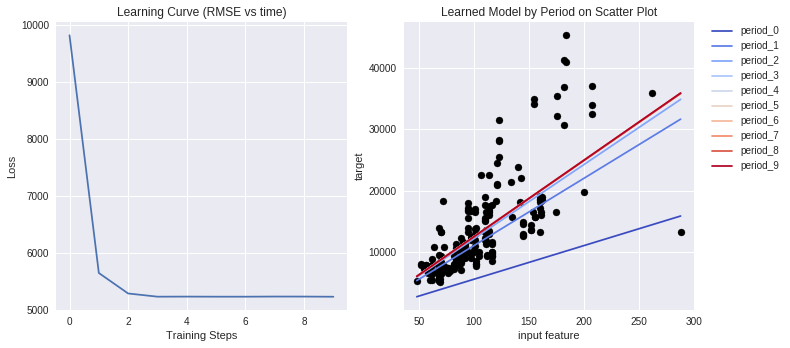

In [0]:
LEARNING_RATE = 0.011
BATCH_SIZE = 50
STEPS = 10000
#PLOT 5; 5226.444; 10,000
linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model_with_one_numerical_feature(
    linear_regressor, training_examples[NUMERICAL_FEATURES],
    training_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Loss after period 00 : 8845.236
  Loss after period 01 : 5428.775
  Loss after period 02 : 5228.199
  Loss after period 03 : 5227.988
  Loss after period 04 : 5226.469
  Loss after period 05 : 5226.109
  Loss after period 06 : 5227.437
  Loss after period 07 : 5227.234
  Loss after period 08 : 5224.104
  Loss after period 09 : 5217.012
Final Loss (RMSE) on the training data: 5217.012


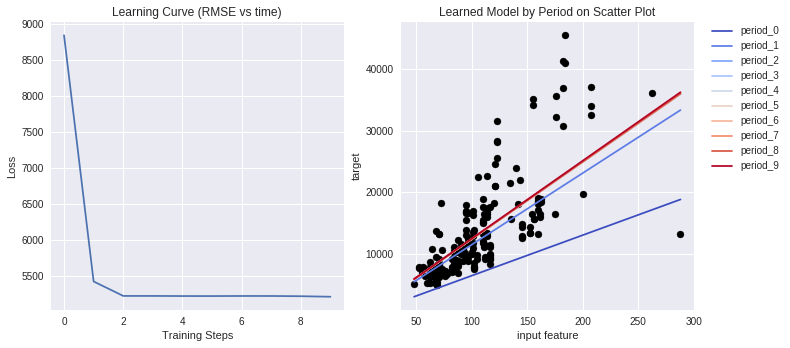

In [0]:
LEARNING_RATE = 0.0131
BATCH_SIZE = 50
STEPS = 10000
#PLOT 6; 5217.012; 10,000
linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model_with_one_numerical_feature(
    linear_regressor, training_examples[NUMERICAL_FEATURES],
    training_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Loss after period 00 : 6162.815
  Loss after period 01 : 5227.219
  Loss after period 02 : 5227.362
  Loss after period 03 : 5225.017
  Loss after period 04 : 5226.074
  Loss after period 05 : 5225.342
  Loss after period 06 : 5223.762
  Loss after period 07 : 5222.170
  Loss after period 08 : 5222.345
  Loss after period 09 : 5221.393
Final Loss (RMSE) on the training data: 5221.393


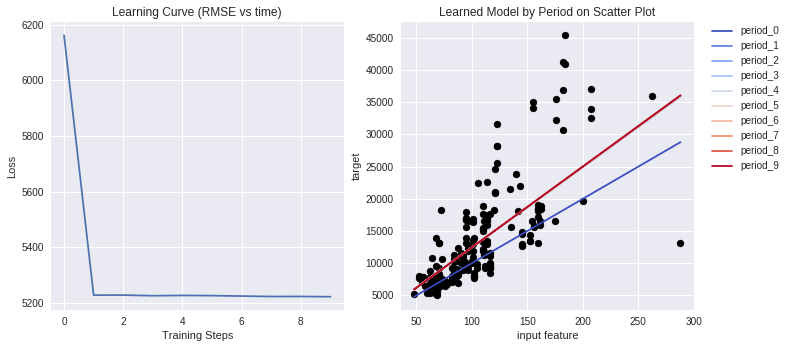

In [0]:
LEARNING_RATE = 0.002
BATCH_SIZE = 50
STEPS = 100000
#PLOT 7 ; 5221.393; 100,000
linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model_with_one_numerical_feature(
    linear_regressor, training_examples[NUMERICAL_FEATURES],
    training_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

In [0]:
"""
List at least 3 of the sets of hyperparameters you tried and the RMSE obtained.
Your primary goal is to get the lowest RMSE you can.  Once you've done that a
secondary goal is to minmize the number of steps used since the computation
cost depends heavily on the number of steps.

Please Submit this with the results from the hyperparameters that you feel
worked best.

LIANNE SANCHEZ'S ANSWER:
 
FOR ME THE BEST 3 sets of hyperparameters were: 
  1. PLOT 6; RMSE: 5217.012; STEPS: 10,000;     LEARNING RATE: 0.0131;  BATCH: 50 -> BEST
  2. PLOT 7; RMSE: 5221.393; STEPS: 100,000;    LEARNING RATE: 0.002;   BATCH: 50
  3. PLOT 1; RMSE: 5224.981; STEPS: 100,000;    LEARNING RATE: 0.001;   BATCH: 50
  
  The best plot that gave the lowest rmse with the fewer steps possible was 
  option and the lowest RMSE.

EVEN THOUGH 
  1. PLOT 2; RMSE: 5170.073; STEPS: 1,000,000;  LEARNING RATE: 0.003;   BATCH: 50 -> ULTIMATE BEST BUT SLOWER!!!!
  
  Was the actual best RMSE but the number of steps is a million and this makes
  the process is extremely slow. If we only take into account the RMSE then the 
  best plot is Plot 2. But taking into account steps I believe Plot 6 is then 
  better because its faster.
  

  TOTAL of PLOTS THAT I TRIED: 
  #PLOT 1; RMSE: 5224.981; STEPS: 100,000;    LEARNING RATE: 0.001;   BATCH: 50
  #PLOT 2; RMSE: 5170.073; STEPS: 1,000,000;  LEARNING RATE: 0.003;   BATCH: 50
  #PLOT 3; RMSE: 5228.063; STEPS: 10,000;     LEARNING RATE: 0.02;    BATCH: 50
  #PLOT 4; RMSE: 5228.717; STEPS: 10,000;     LEARNING RATE: 0.015;   BATCH: 50
  #PLOT 5; RMSE: 5226.444; STEPS: 10,000;     LEARNING RATE: 0.011;   BATCH: 50
  #PLOT 6; RMSE: 5217.012; STEPS: 10,000;     LEARNING RATE: 0.0131;  BATCH: 50
  #PLOT 7; RMSE: 5221.393; STEPS: 100,000;    LEARNING RATE: 0.002;   BATCH: 50
"""

##Exercise: Try a Different Input Feature (3 Points)

The choice of the hyperparameters depedns a lot on the data set and what you are trying to learn.  In this task you will try to predict the price from highway mpg. In this task you will find a good set of hyperparmeters for this problem.

* Use highway-mpg instead of horsepower to predict price  You might want to start by just plotting the data.  What do you observe?
* What hyperparameters give you the best trained model that you can get.  Try to keep the learning steps as small as you can while still training a good model.
* Did you have to change the hyperparameters a lot?  If you did, why do you think that might be the case?
* How does the RMSE for your model compare to the optimal RMSE?  Think about what you'll need to do in order to answer this question.

In [0]:
NUMERICAL_FEATURES = ["highway-mpg"]
CATEGORICAL_FEATURES = []
LABEL = "price"

## Fill in the rest of your solution here.

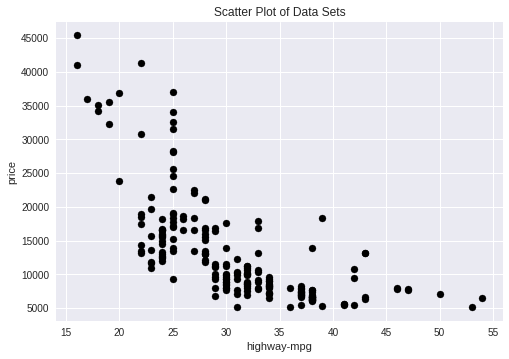

In [0]:
#STEP 1: PLOTTING THE DATA
plt.ylabel(LABEL)
plt.xlabel("highway-mpg")
plt.scatter(car_data['highway-mpg'] , car_data['price'], c='black')
plt.title('Scatter Plot of Data Sets')
plt.show()

Training model...
  Loss after period 00 : 9449.972
  Loss after period 01 : 9021.915
  Loss after period 02 : 8609.208
  Loss after period 03 : 8224.572
  Loss after period 04 : 7855.178
  Loss after period 05 : 7488.597
  Loss after period 06 : 7120.498
  Loss after period 07 : 6904.171
  Loss after period 08 : 6724.739
  Loss after period 09 : 6573.031
Final Loss (RMSE) on the training data: 6573.031


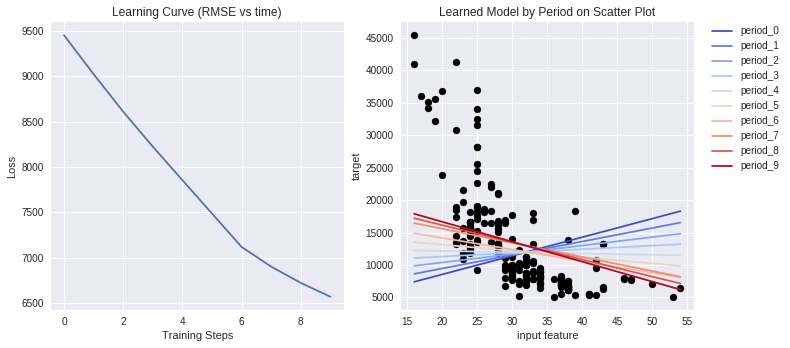

In [0]:
#STEP 2: WHAT HYPERPARAMETERS ARE THE BEST TRAINED
LEARNING_RATE = 10
BATCH_SIZE = 50
STEPS = 10000

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model_with_one_numerical_feature(
    linear_regressor, training_examples[NUMERICAL_FEATURES],
    training_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Loss after period 00 : 9257.729
  Loss after period 01 : 7348.942
  Loss after period 02 : 6994.332
  Loss after period 03 : 6706.530
  Loss after period 04 : 6488.027
  Loss after period 05 : 6322.456
  Loss after period 06 : 6199.534
  Loss after period 07 : 6108.443
  Loss after period 08 : 6045.325
  Loss after period 09 : 6000.406
Final Loss (RMSE) on the training data: 6000.406


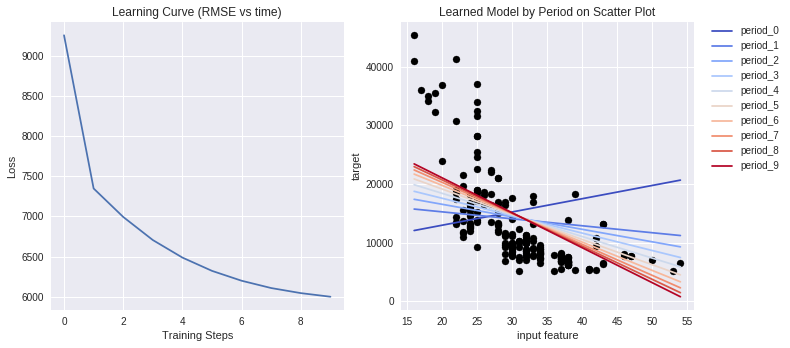

In [0]:
LEARNING_RATE = 23
BATCH_SIZE = 50
STEPS = 20000

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model_with_one_numerical_feature(
    linear_regressor, training_examples[NUMERICAL_FEATURES],
    training_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Loss after period 00 : 6963.724
  Loss after period 01 : 6240.646
  Loss after period 02 : 6026.041
  Loss after period 03 : 5967.924
  Loss after period 04 : 5939.456
  Loss after period 05 : 5924.228
  Loss after period 06 : 5920.329
  Loss after period 07 : 5923.578
  Loss after period 08 : 5923.020
  Loss after period 09 : 5924.099
Final Loss (RMSE) on the training data: 5924.099


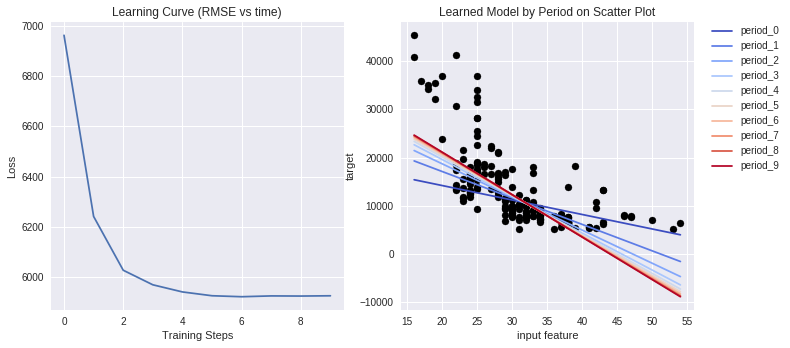

In [0]:
LEARNING_RATE = 18
BATCH_SIZE = 50
STEPS = 60000

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model_with_one_numerical_feature(
    linear_regressor, training_examples[NUMERICAL_FEATURES],
    training_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Loss after period 00 : 8977.592
  Loss after period 01 : 8140.302
  Loss after period 02 : 7425.519
  Loss after period 03 : 6846.564
  Loss after period 04 : 6374.375
  Loss after period 05 : 6011.654
  Loss after period 06 : 5811.464
  Loss after period 07 : 5729.652
  Loss after period 08 : 5699.552
  Loss after period 09 : 5686.829
Final Loss (RMSE) on the training data: 5686.829


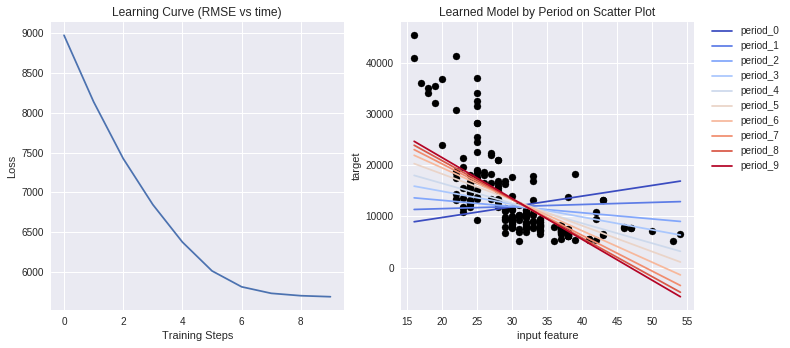

In [0]:
LEARNING_RATE = 1
BATCH_SIZE = 50
STEPS = 70000

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model_with_one_numerical_feature(
    linear_regressor, training_examples[NUMERICAL_FEATURES],
    training_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Training model...
  Loss after period 00 : 8572.012
  Loss after period 01 : 7471.437
  Loss after period 02 : 6632.895
  Loss after period 03 : 6082.460
  Loss after period 04 : 5790.598
  Loss after period 05 : 5699.503
  Loss after period 06 : 5678.491
  Loss after period 07 : 5705.068
  Loss after period 08 : 5694.222
  Loss after period 09 : 5700.359
Final Loss (RMSE) on the training data: 5700.359


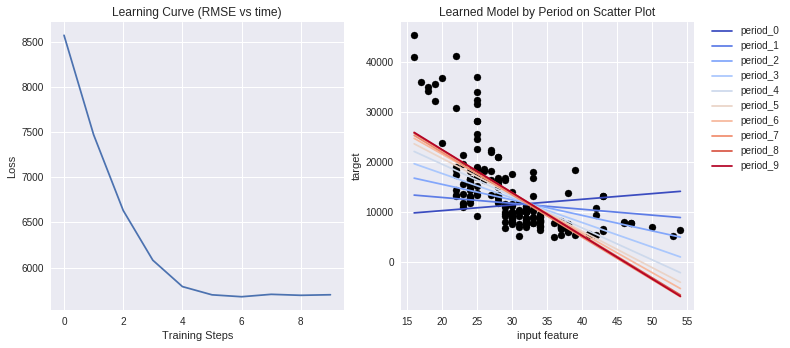

In [0]:
LEARNING_RATE = 1
BATCH_SIZE = 50
STEPS = 100000

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model_with_one_numerical_feature(
    linear_regressor, training_examples[NUMERICAL_FEATURES],
    training_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

In [0]:
#STEP 4: OPTIMAL RMSE 
x = car_data['highway-mpg']
y = car_data['price']
opt = np.polyfit(x, y, 1)
y_pred = opt[0] * x + opt[1]
opt_rmse = math.sqrt(metrics.mean_squared_error(y_pred, y))
slope = opt[0]
bias = opt[1]
print("Optimal RMSE") 
print( opt_rmse)

Optimal RMSE
5677.64284623


In [0]:
"""
TYPE YOUR ANSWERS TO THE GIVEN QUESTIONS HERE
LIANNE SANCHEZ'S RESULTS:
  1. What do you observe?
        The highway-mpg is in the x-axis representing the highway milleage per
        gallon and the y-axis is representing the price of the cars. By the plot
        shown we can observe that the higher the highway-mpg the cheaper the car 
        cost. Which could mean that the less highway-mpg the more expensive is
        the car. 
      
  2. What hyperparameters give you the best trained model that you can get?
        The best hyperparameters that gave me the lowest RMSE was when the 
        learning rate is 1, the batch size is 50 and the steps are 70,000.
        Thus, giving the RMSE is 5,686.359. 
        
  3. Did you have to change the hyperparameters a lot? If you did, why do you 
     think that might be the case?
        Yes, I had to change the parameters a lot. I believe because first, the 
        data is different than from task 1. It is difficult to just give a good
        guest as the first time. I believe it took several iterations because it 
        took time to see the learning curve, analize it and adapt my parameters 
        little by little in order to get the best results possible.
        
  4. How does the RMSE for your model compare to the optimal RMSE? Think about 
     what you'll need to do in order to answer this question. 
        In order to answer this question I had to find the optimal rmse
        I had to use the polyfit in order to find it. The optimal rmse is 
        5677.64 vs my approximations which is 5,686.359. My optimal rmse is 
        worse but it is not that far away from the optimal rmse. The percentage 
        of error between my value and the optimal is:
              
                   % error = (|5,686.359 - 5,677.64|/5,677.64) * 100
                   % error = 1.54% 
"""